# Sizing of locked token deals - how much to short at entry (t0)?
This notebook analyses the payoff schemes with a different ratios of short and long leg for token deals (i.e. deals entered into with discount). The objective is to find the optimal sizing, that will allow us to cap the downside risk, but leave the upside unlimited. 
First, we start with a simple model that analyzes the payoff structures of the trade without additional factors such as funding rates and/or capital inefficiencies. These are included later on. We use the JUP trade to illustrate with the following params: 22 months, 0.55 market price, 25% discount.

## Simple toy-model
We start of with charting the payoff structures of the trade for different short/long ratios. We can see that as we increase the % shorted, we limit our exposure to the downside (we lower the slope of the PnL line), but in doing so, we also limit the upside we can capture. Note that PnL of short leg is always 0 in the worst case, as we cover the loss with the spot tokens that we receive in the future.

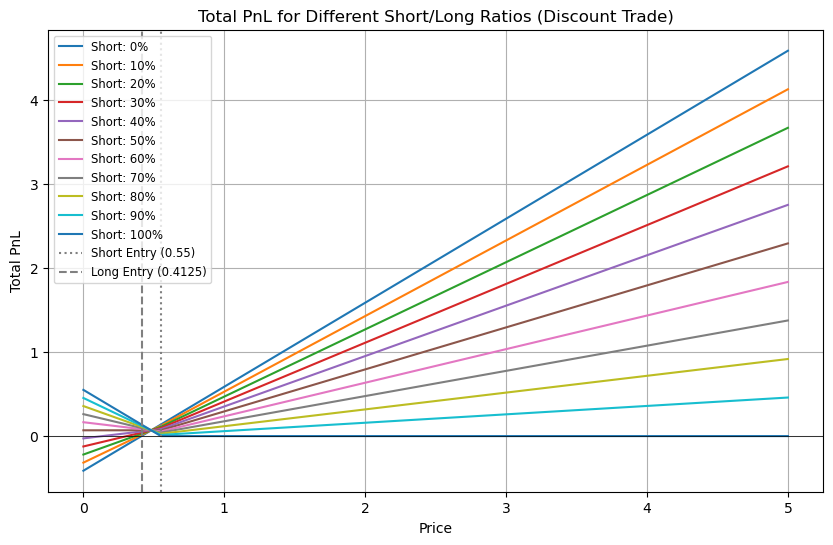

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
prices = np.linspace(0, 5, 1001)  # Prices from 0 to 5
discount = 0.25
entry_short = 0.55              # Market short entry price
entry_long = (1 - discount) * entry_short  # Discounted purchase price (0.4125)

plt.figure(figsize=(10, 6))

# In this structure, you always hold the tokens (100% long)
# and you short a fraction (w_short) of your position.
for w_short in np.arange(0, 1.01, 0.1):
    w_long = 1 - w_short
    # Long PnL (always 100% long)
    long_pnl = w_long * (prices - entry_long)
    # Short PnL is applied only to the fraction that is shorted
    short_pnl = np.maximum(w_short * (entry_short - prices), 0)
    # Total PnL: sum of long and short components
    total_pnl = long_pnl + short_pnl
    
    label_str = f"Short: {w_short*100:.0f}%"
    plt.plot(prices, total_pnl, label=label_str)

# Add vertical lines for entry prices
plt.axvline(entry_short, color='gray', linestyle=':', label='Short Entry (0.55)')
plt.axvline(entry_long, color='gray', linestyle='--', label='Long Entry (0.4125)')
plt.axhline(0, color='black', linewidth=0.5)
plt.title('Total PnL for Different Short/Long Ratios (Discount Trade)')
plt.xlabel('Price')
plt.ylabel('Total PnL')
plt.legend(loc='best', fontsize='small')
plt.grid(True)
plt.show()


The first objective therefore is to find the optimal short % that will allow us to capture the most upside, while also capping our exposure to the downside. In order to do that, let us initially analyze the payoff structure of both legs for 50% short ratio (the one we did with AVAX).

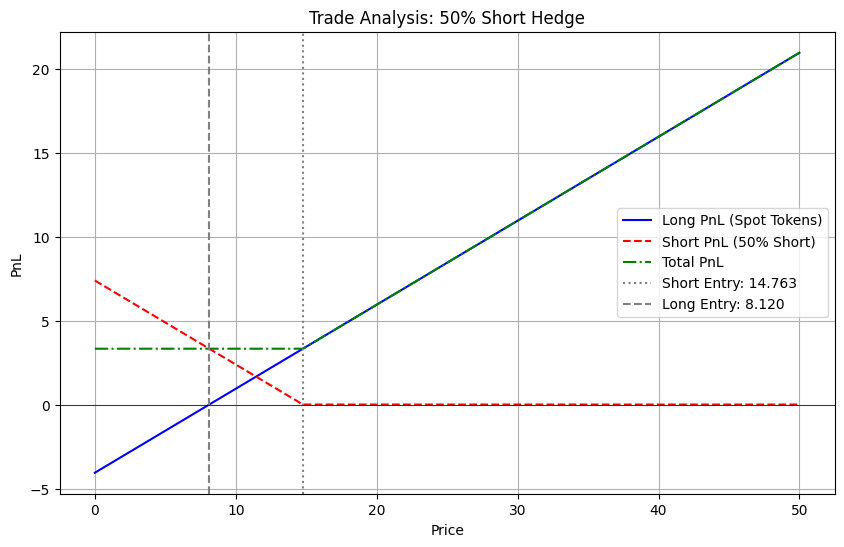

Minimum Total PnL: 3.321656840249999
Maximum Total PnL: 20.94019719525


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
prices = np.linspace(0, 50, 1001)  # Price range from 0 to 5
discount = 0.45
entry_short = 14.76291929              # Market price for the short entry
entry_long = (1 - discount) * entry_short  # Discounted purchase price, e.g., 0.4125
w_short = 0.5 # 50% short hedge
w_long = 1 - w_short

# Calculate each leg's PnL:
long_pnl = w_long * (prices - entry_long)
short_pnl = np.maximum(entry_short - prices, 0) * w_short
total_pnl = long_pnl + short_pnl

# Plotting the legs and the total PnL
plt.figure(figsize=(10, 6))
plt.plot(prices, long_pnl, label='Long PnL (Spot Tokens)', linestyle='-', color='blue')
plt.plot(prices, short_pnl, label='Short PnL (50% Short)', linestyle='--', color='red')
plt.plot(prices, total_pnl, label='Total PnL', linestyle='-.', color='green')

# Add vertical lines for entry prices:
plt.axvline(entry_short, color='gray', linestyle=':', linewidth=1.5, label=f'Short Entry: {entry_short:.3f}')
plt.axvline(entry_long, color='gray', linestyle='--', linewidth=1.5, label=f'Long Entry: {entry_long:.3f}')
plt.axhline(0, color='black', linewidth=0.5)
plt.title('Trade Analysis: 50% Short Hedge')
plt.xlabel('Price')
plt.ylabel('PnL')
plt.legend(loc='best')
plt.grid(True)
plt.show()
print("Minimum Total PnL:", np.min(total_pnl))
print("Maximum Total PnL:", np.max(total_pnl))

As we can see in the chart, hedging 50% at t0, we "fix" that the trade will always be profitable as long as we can settle the spot tokens and the short perp. But this is not necessarily the best approach as it can be capital intensive, expose us unnecessarily to funding rates, and, perhaps most importantly, it is suboptimal wrt capturing the upside. So we need to find a better payoff structure. We will do that by solving for an unknown short % that will be subject to two constraints: a) minimum PnL will be 0, and b) it will have higher maximum PnL than the 50% short ratio structure.

Optimal w_short (for min PnL = 0): 0.42857142857142855
Optimal w_long: 0.5714285714285714


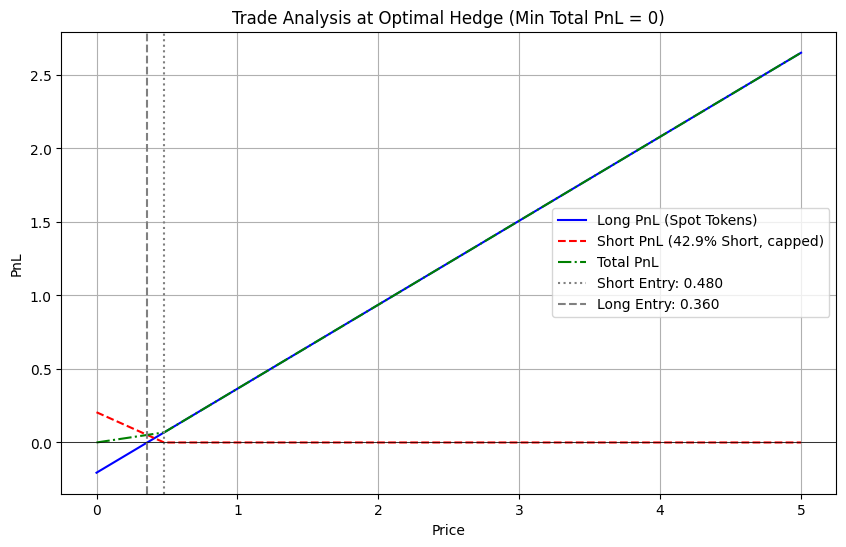

Minimum Total PnL: 0.0
Maximum total PnL: 2.6514285714285712


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

# Parameters
discount = 0.25
entry_short = 0.48                       
entry_long = (1 - discount) * entry_short    

# Function for total PnL at price=0 (worst-case)
def total_pnl_at_zero(w_short):
    return w_short * entry_short - (1 - w_short) * entry_long

# Use scipy.optimize.brentq to find w_short numerically
optimal_w_short = brentq(total_pnl_at_zero, 0, 1)
optimal_w_long = 1 - optimal_w_short

print("Optimal w_short (for min PnL = 0):", optimal_w_short)
print("Optimal w_long:", optimal_w_long)

# Plotting PnL at optimal weights
prices = np.linspace(0, 5, 1001)  

long_pnl = optimal_w_long * (prices - entry_long)
short_pnl = np.maximum(entry_short - prices, 0) * optimal_w_short
total_pnl = long_pnl + short_pnl

plt.figure(figsize=(10, 6))
plt.plot(prices, long_pnl, label='Long PnL (Spot Tokens)', linestyle='-', color='blue')
plt.plot(prices, short_pnl, label=f'Short PnL ({optimal_w_short*100:.1f}% Short, capped)', linestyle='--', color='red')
plt.plot(prices, total_pnl, label='Total PnL', linestyle='-.', color='green')
plt.axvline(entry_short, color='gray', linestyle=':', linewidth=1.5, label=f'Short Entry: {entry_short:.3f}')
plt.axvline(entry_long, color='gray', linestyle='--', linewidth=1.5, label=f'Long Entry: {entry_long:.3f}')
plt.axhline(0, color='black', linewidth=0.5)
plt.title('Trade Analysis at Optimal Hedge (Min Total PnL = 0)')
plt.xlabel('Price')
plt.ylabel('PnL')
plt.legend(loc='best')
plt.grid(True)
plt.show()
print("Minimum Total PnL:", np.min(total_pnl))
print("Maximum total PnL:", np.max(total_pnl))

Optimal w_short (for min PnL = 0 at price floor): 0.40625
Optimal w_long: 0.59375


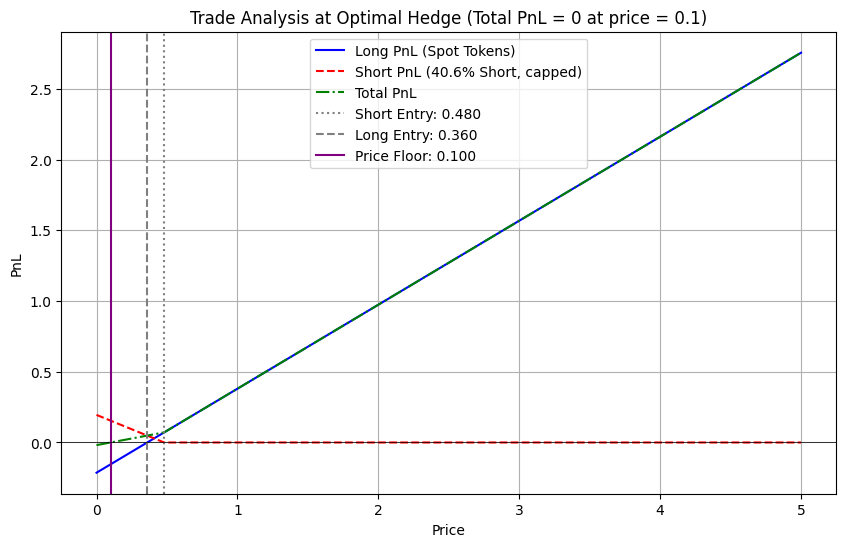

Minimum Total PnL: -0.01874999999999999
Maximum Total PnL: 2.755


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

# Parameters
discount = 0.25
entry_short = 0.48                       
entry_long = (1 - discount) * entry_short

# Adjustable price floor (user-defined)
price_floor = 0.1  # Change this value to your desired price floor

# Function for total PnL at adjustable price floor
def total_pnl_at_floor(w_short):
    long_pnl_floor = (1 - w_short) * (price_floor - entry_long)
    short_pnl_floor = np.maximum(entry_short - price_floor, 0) * w_short
    return long_pnl_floor + short_pnl_floor

# Find optimal short weight numerically
optimal_w_short = brentq(total_pnl_at_floor, 0, 1)
optimal_w_long = 1 - optimal_w_short

print("Optimal w_short (for min PnL = 0 at price floor):", optimal_w_short)
print("Optimal w_long:", optimal_w_long)

# Plotting PnL at optimal weights
prices = np.linspace(0, 5, 1001)  

long_pnl = optimal_w_long * (prices - entry_long)
short_pnl = np.maximum(entry_short - prices, 0) * optimal_w_short
total_pnl = long_pnl + short_pnl

plt.figure(figsize=(10, 6))
plt.plot(prices, long_pnl, label='Long PnL (Spot Tokens)', linestyle='-', color='blue')
plt.plot(prices, short_pnl, label=f'Short PnL ({optimal_w_short*100:.1f}% Short, capped)', linestyle='--', color='red')
plt.plot(prices, total_pnl, label='Total PnL', linestyle='-.', color='green')

# Plot important price points
plt.axvline(entry_short, color='gray', linestyle=':', linewidth=1.5, label=f'Short Entry: {entry_short:.3f}')
plt.axvline(entry_long, color='gray', linestyle='--', linewidth=1.5, label=f'Long Entry: {entry_long:.3f}')
plt.axvline(price_floor, color='purple', linestyle='-', linewidth=1.5, label=f'Price Floor: {price_floor:.3f}')

plt.axhline(0, color='black', linewidth=0.5)

# Plot labels and styling
plt.title(f'Trade Analysis at Optimal Hedge (Total PnL = 0 at price = {price_floor})')
plt.xlabel('Price')
plt.ylabel('PnL')
plt.legend(loc='best')
plt.grid(True)
plt.show()

print("Minimum Total PnL:", np.min(total_pnl))
print("Maximum Total PnL:", np.max(total_pnl))

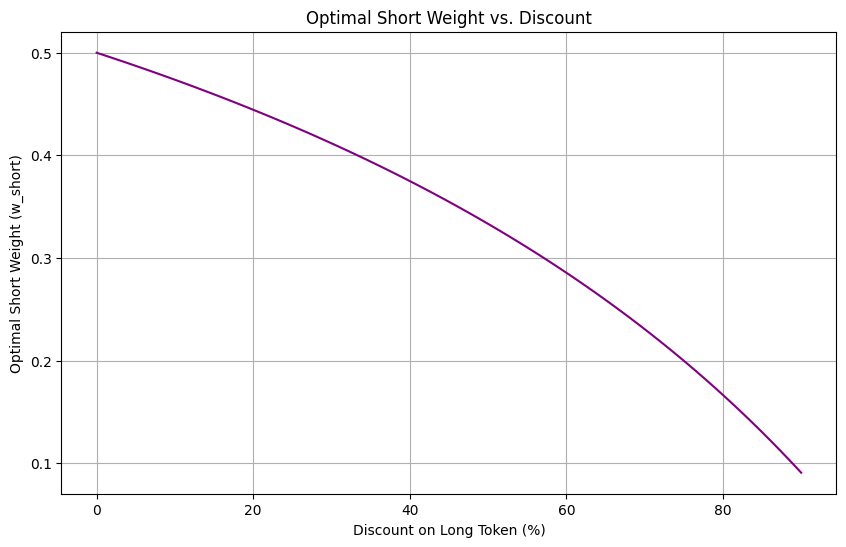

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq

# Fixed short entry price - here JUP price, but can be anything for the simulation
entry_short = 0.4745

# Discount range (e.g., from 0% to 90%)
discounts = np.linspace(0, 0.9, 100)
optimal_w_shorts = []

# Define function to compute optimal w_short at a given discount
def find_optimal_w_short(discount):
    entry_long = (1 - discount) * entry_short

    def total_pnl_at_zero(w_short):
        return w_short * entry_short - (1 - w_short) * entry_long

    return brentq(total_pnl_at_zero, 0, 1)

# Calculate optimal short weight for each discount
for d in discounts:
    w_short = find_optimal_w_short(d)
    optimal_w_shorts.append(w_short)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(discounts * 100, optimal_w_shorts, color='purple')
plt.title("Optimal Short Weight vs. Discount")
plt.xlabel("Discount on Long Token (%)")
plt.ylabel("Optimal Short Weight (w_short)")
plt.grid(True)
plt.show()


By lowering the initial short ratio by 7,14%, we can capture larger upside, while still limiting the worst outcome of the trade to 0 (which would happen only if prices went to 0, which means we can do this exercise also with some pre-defined "floor price", which we believe the prices will not get below and optimize for that). Lowering the amount shorted at t0 has more benefits than just capturing the upside (obviously this strategy fits well only for tokens we are bullish on, if we buy shitcoins, we should reverse it and show our bias that way) - the lower quantity we short, the less we are exposed to funding rates and the less capital we need to hold on the CEX. We have shown the simulation of this for a different discounts - as expected, the larger the discount, the less we need to short in order to fix PnL at 0.

In line with this, the second goal of this sizing exercise will be to find some heuristic that will allow us to adjust the initial sizing based on the historical funding rates..

## Sizing with funding rates (Work in progress)

There are multiple approaches to account for the impact of funding rates on the payoff structure of perpetual futures. A simple and effective way is to **deterministically calculate a funding rate factor**, which adjusts the payoff based on the average annual funding rate and the holding period of the trade. This factor is calculated using compound interest as follows:


Funding Factor = (1 + r)^T


Where:

- \( r \) = Mean annual funding rate (negative if you pay funding, positive if you receive funding).
- \( T \) = Holding period in years (e.g., 1.0 for one year).

The interpretation of the `funding_factor` is:

- Exactly **1.0** if the funding rate is zero.
- Between **0 and 1** if funding rates are negative (indicating you pay funding to maintain the short position).
- Greater than **1.0** if funding rates are positive (indicating you earn funding from the short position).

Once calculated, the funding cost of the short position is determined as:


Funding Cost = Weight Short * (Funding Factor - 1)


This expression essentially takes the notional of the short position (represented by `weight_short` for 1 unit of exposure) and adjusts it by the impact of the funding factor.


🧭 Minimum Viable Max Loss: 0.0061%
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3999995930989646
            Iterations: 3
            Function evaluations: 6
            Gradient evaluations: 3

✅ Constrained Optimal Short Weight: 0.400000
✅ Worst-case Total PnL: -0.000061
✅ Best-case Total PnL: 228.000155
🔍 Worst-case Price: 0.000


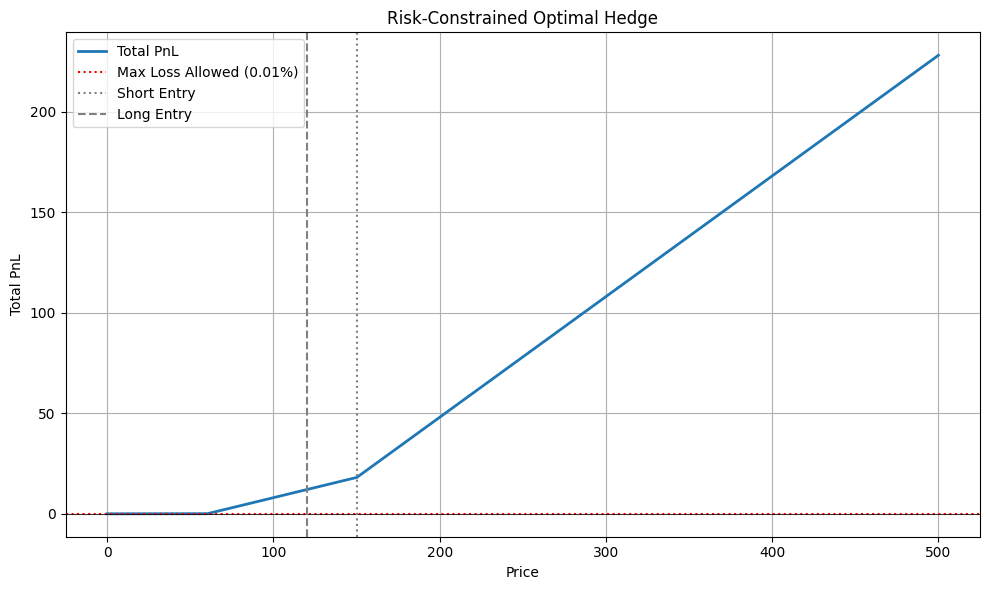

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# --- Parameters ---
entry_short = 150
discount = 0.2
entry_long = (1 - discount) * entry_short
annual_rate = 0
period_fraction = 34/12  # years
prices = np.linspace(0, 500, 100001)
price_floor = 60

def compute_funding_factor(annual_rate_percent, period_fraction, compounding="8h", frequency_per_year=1095):
    r = annual_rate_percent / 100.0
    if compounding == "8h":
        return (1 + r / frequency_per_year) ** (frequency_per_year * period_fraction)
    else:
        return 1 + r * period_fraction

funding_factor = compute_funding_factor(annual_rate, period_fraction)

# --- Total PnL as a function of w_short ---

def total_pnl_vector(w_short):
    w_long = 1 - w_short
    adjusted_prices = np.maximum(prices, price_floor)  # 🧹 NEW: enforce price floor

    short_raw_pnl = np.maximum(entry_short - adjusted_prices, 0) * w_short
    funding_cost = (funding_factor - 1) * w_short
    short_pnl = short_raw_pnl + funding_cost

    long_pnl = (adjusted_prices - entry_long) * w_long

    return short_pnl + long_pnl

# --- Objective: minimize short weight
def objective(w):
    return w[0]

# --- Binary search for minimum viable loss
def find_min_viable_loss(tol=1e-4, max_iter=50):
    low = 0.0
    high = 0.5  # don't expect user to tolerate >50% loss
    for _ in range(max_iter):
        mid = (low + high) / 2

        def constraint(w):
            return np.min(total_pnl_vector(w[0])) + mid

        result = minimize(
            objective,
            x0=[0.7],
            bounds=[(0, 1)],
            constraints={"type": "ineq", "fun": constraint},
            method='SLSQP',
            options={"maxiter": 500, "ftol": 1e-9, "disp": False}
        )

        if result.success:
            high = mid
        else:
            low = mid

        if high - low < tol:
            break

    return high

# --- Step 1: Find minimum acceptable drawdown
min_loss = find_min_viable_loss()
print(f"🧭 Minimum Viable Max Loss: {min_loss:.4%}")

# --- Step 2: Run optimization with this loss tolerance
def constraint(w):
    return np.min(total_pnl_vector(w[0])) + min_loss

result = minimize(
    objective,
    x0=[0.7],
    bounds=[(0, 1)],
    constraints={"type": "ineq", "fun": constraint},
    method='SLSQP',
    options={"maxiter": 1000, "ftol": 1e-10, "disp": True}
)

# --- Step 3: Plot and analyze result
if result.success:
    optimal_w_short = result.x[0]
    optimal_w_long = 1 - optimal_w_short
    optimal_total_pnl = total_pnl_vector(optimal_w_short)
    worst_case_price = prices[np.argmin(optimal_total_pnl)]

    print(f"\n✅ Constrained Optimal Short Weight: {optimal_w_short:.6f}")
    print(f"✅ Worst-case Total PnL: {np.min(optimal_total_pnl):.6f}")
    print(f"✅ Best-case Total PnL: {np.max(optimal_total_pnl):.6f}")
    print(f"🔍 Worst-case Price: {worst_case_price:.3f}")

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(prices, optimal_total_pnl, label='Total PnL', linewidth=2)
    plt.axhline(-min_loss, color='red', linestyle=':', label=f"Max Loss Allowed ({min_loss:.2%})")
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(entry_short, color='gray', linestyle=':', label='Short Entry')
    plt.axvline(entry_long, color='gray', linestyle='--', label='Long Entry')
    plt.title('Risk-Constrained Optimal Hedge')
    plt.xlabel('Price')
    plt.ylabel('Total PnL')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print("❌ Optimization failed:", result.message)

Period: 1.83 yrs: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


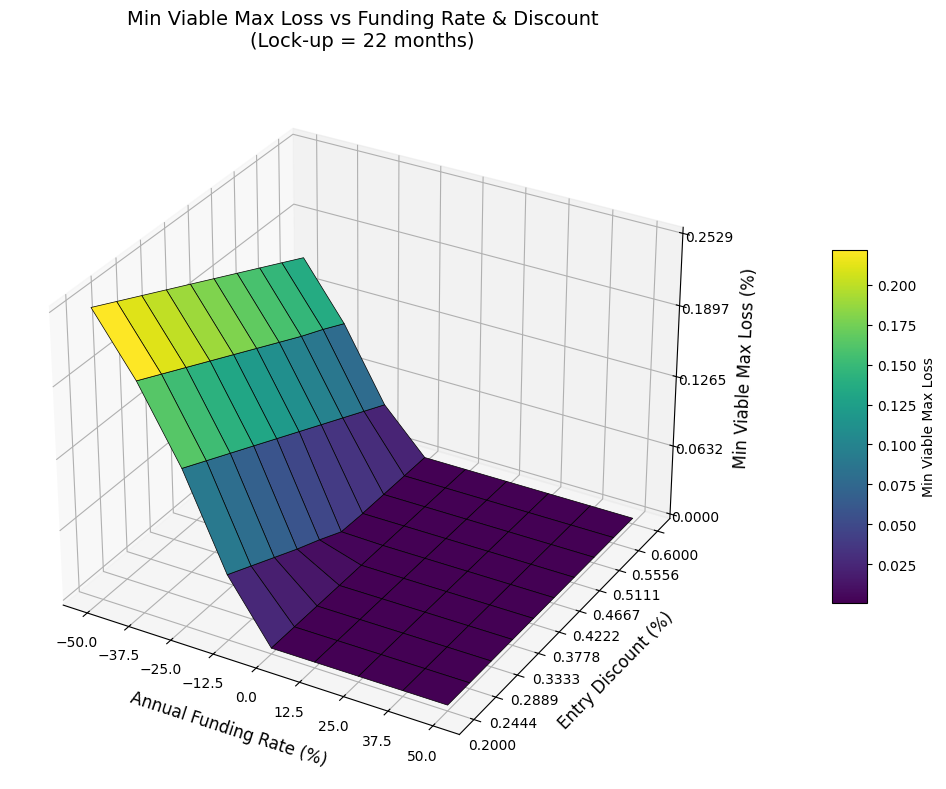

In [13]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D

def compute_funding_factor(annual_rate_percent, period_fraction, compounding="8h", frequency_per_year=1095):
    r = annual_rate_percent / 100.0
    if compounding == "8h":
        return (1 + r / frequency_per_year) ** (frequency_per_year * period_fraction)
    else:
        return 1 + r * period_fraction

def compute_min_viable_loss(entry_short, discount, annual_rate, period_fraction, prices):
    entry_long = (1 - discount) * entry_short
    funding_factor = compute_funding_factor(annual_rate, period_fraction)

    def total_pnl_vector(w_short):
        w_long = 1 - w_short
        short_raw_pnl = np.maximum(entry_short - prices, 0) * w_short
        funding_cost = (funding_factor - 1) * w_short
        short_pnl = short_raw_pnl + funding_cost
        long_pnl = (prices - entry_long) * w_long
        return short_pnl + long_pnl

    def objective(w):
        return w[0]

    def find_min_loss(tol=1e-3, max_iter=40):
        low = 0.0
        high = 0.5
        for _ in range(max_iter):
            mid = (low + high) / 2

            def constraint(w):
                return np.min(total_pnl_vector(w[0])) + mid

            result = minimize(
                objective,
                x0=[0.7],
                bounds=[(0, 1)],
                constraints={"type": "ineq", "fun": constraint},
                method='SLSQP',
                options={"maxiter": 300, "ftol": 1e-8, "disp": False}
            )

            if result.success:
                high = mid
            else:
                low = mid

            if high - low < tol:
                break

        return high

    return find_min_loss()

# Parameters
entry_short = 0.48
prices = np.linspace(0, 2, 500)
funding_rates = np.linspace(-50, 50, 9)
discounts = np.linspace(0.2, 0.6, 10)
periods = [22/12]  # 22 months

# Run simulation
results = {}
for period in periods:
    Z = np.zeros((len(discounts), len(funding_rates)))
    for i in tqdm(range(len(discounts)), desc=f"Period: {period:.2f} yrs"):
        discount = discounts[i]
        for j, rate in enumerate(funding_rates):
            loss = compute_min_viable_loss(entry_short, discount, rate, period, prices)
            Z[i, j] = loss
    results[period] = Z

# Plot 3D surface for the 22-month period
X, Y = np.meshgrid(funding_rates, discounts)
Z = results[periods[0]]

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='k', linewidth=0.5, antialiased=True)

# Titles & Labels
ax.set_title("Min Viable Max Loss vs Funding Rate & Discount\n(Lock-up = 22 months)", fontsize=14, pad=20)
ax.set_xlabel("Annual Funding Rate (%)", labelpad=10, fontsize=12)
ax.set_ylabel("Entry Discount (%)", labelpad=10, fontsize=12)
ax.set_zlabel("Min Viable Max Loss (%)", labelpad=10, fontsize=12)

# Format axes ticks
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='z', labelsize=10)

# Set readable axis ranges
ax.set_xticks(funding_rates)
ax.set_yticks(discounts)
ax.set_zticks(np.linspace(0, np.max(Z), 5))

# Add color bar
fig.colorbar(surf, shrink=0.5, aspect=10, pad=0.1, label='Min Viable Max Loss')



plt.tight_layout()
plt.show()



In [27]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, FloatSlider, IntSlider, VBox, Label
from scipy.optimize import minimize

# --- Funding factor ---
def compute_funding_factor(annual_rate_percent, period_fraction, compounding="8h", frequency_per_year=1095):
    r = annual_rate_percent / 100.0
    if compounding == "8h":
        return (1 + r / frequency_per_year) ** (frequency_per_year * period_fraction)
    else:
        return 1 + r * period_fraction

# --- Optimization logic ---
def compute_min_viable_loss(entry_short, discount, annual_rate, period_fraction, prices):
    entry_long = (1 - discount) * entry_short
    funding_factor = compute_funding_factor(annual_rate, period_fraction)

    def total_pnl_vector(w_short):
        w_long = 1 - w_short
        short_raw_pnl = np.maximum(entry_short - prices, 0) * w_short
        funding_cost = (funding_factor - 1) * w_short
        short_pnl = short_raw_pnl + funding_cost
        long_pnl = (prices - entry_long) * w_long
        return short_pnl + long_pnl

    def objective(w):
        return w[0]

    def find_min_loss(tol=1e-3, max_iter=40):
        low = 0.0
        high = 0.5
        optimal_weight = np.nan
        for _ in range(max_iter):
            mid = (low + high) / 2

            def constraint(w):
                return np.min(total_pnl_vector(w[0])) + mid

            result = minimize(
                objective,
                x0=[0.7],
                bounds=[(0, 1)],
                constraints={"type": "ineq", "fun": constraint},
                method='SLSQP',
                options={"maxiter": 300, "ftol": 1e-8, "disp": False}
            )

            if result.success:
                optimal_weight = result.x[0]
                high = mid
            else:
                low = mid

            if high - low < tol:
                break

        return high, optimal_weight

    return find_min_loss()

# --- Interactive plot function ---
def interactive_hedge(discount=0.2, annual_rate=0, months=34):
    entry_short = 150
    period_fraction = months / 12
    prices = np.linspace(0, 500, 5000)
    
    min_loss, short_weight = compute_min_viable_loss(entry_short, discount, annual_rate, period_fraction, prices)
    entry_long = (1 - discount) * entry_short
    funding_factor = compute_funding_factor(annual_rate, period_fraction)
    
    w_long = 1 - short_weight
    short_pnl = np.maximum(entry_short - prices, 0) * short_weight + (funding_factor - 1) * short_weight
    long_pnl = (prices - entry_long) * w_long
    total_pnl = short_pnl + long_pnl
    
    plt.figure(figsize=(8, 5))
    plt.plot(prices, total_pnl, label="Total PnL", linewidth=2)
    plt.plot(prices, short_pnl, '--', label="Short PnL")
    plt.plot(prices, long_pnl, ':', label="Long PnL")
    plt.axhline(-min_loss, color='red', linestyle=':', label="Max Total Loss")
    plt.axhline(0, color='black', linewidth=0.5)
    plt.title(f"PnL Curve | Max Loss: -{min_loss:.2%}, Optimal Short Weight: {short_weight:.3f}")
    plt.xlabel("Price")
    plt.ylabel("PnL")
    plt.grid(True)
    plt.legend()
    plt.show()

# --- Display with interactive widgets ---
# Create labeled sliders
discount_slider = FloatSlider(value=0.4, min=0.0, max=0.6, step=0.05, description='Discount')
funding_slider = IntSlider(value=-20, min=-50, max=30, step=5, description='Funding %')
months_slider = IntSlider(value=22, min=1, max=36, step=1, description='Months')

# Build the interactive display
ui = VBox([
    Label("🎛️ Adjust parameters below:")
])

out = interactive(interactive_hedge, discount=discount_slider, annual_rate=funding_slider, months=months_slider)
display(ui, out)

interactive(children=(FloatSlider(value=0.4, description='Discount', max=0.6, step=0.05), IntSlider(value=-20,…

In [54]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

entry_short = 0.45
discount = 0.25
months = 22
period_fraction = months / 12
prices = np.linspace(0, 2, 500)
funding_rates = np.linspace(-50, 30, 81)

fig, ax = plt.subplots(figsize=(12, 6))
line_total, = ax.plot([], [], label="Total PnL", linewidth=2)
line_short, = ax.plot([], [], '--', label="Short PnL")
line_long, = ax.plot([], [], ':', label="Long PnL")
loss_line = ax.axhline(0, color='black', linewidth=0.5)

ax.set_xlim(0, 2)
ax.set_ylim(-0.3, 0.7)
ax.set_xlabel("Price")
ax.set_ylabel("PnL")
ax.grid(True)
ax.legend()

def update(i):
    annual_rate = funding_rates[i]
    min_loss, short_weight = compute_min_viable_loss(entry_short, discount, annual_rate, period_fraction, prices)
    funding_factor = compute_funding_factor(annual_rate, period_fraction)
    entry_long = (1 - discount) * entry_short

    w_long = 1 - short_weight
    short_pnl = np.maximum(entry_short - prices, 0) * short_weight + (funding_factor - 1) * short_weight
    long_pnl = (prices - entry_long) * w_long
    total_pnl = short_pnl + long_pnl

    line_total.set_data(prices, total_pnl)
    line_short.set_data(prices, short_pnl)
    line_long.set_data(prices, long_pnl)
    ax.set_title(f"JUP 25% Discount PnL Curve | Funding = {annual_rate:.1f}% | Max loss: {min_loss:.2%}, Optimal Short Weight (minimizing max loss): {short_weight:.2f}")
    plt.tight_layout()
    return line_total, line_short, line_long

ani = FuncAnimation(fig, update, frames=len(funding_rates), blit=False, interval=200)

# Save as GIF
ani.save("hedge_pnl_vs_funding.gif", writer=PillowWriter(fps=10))
plt.close()

Period: 2.83 yrs: 100%|██████████| 10/10 [00:00<00:00, 32.95it/s]


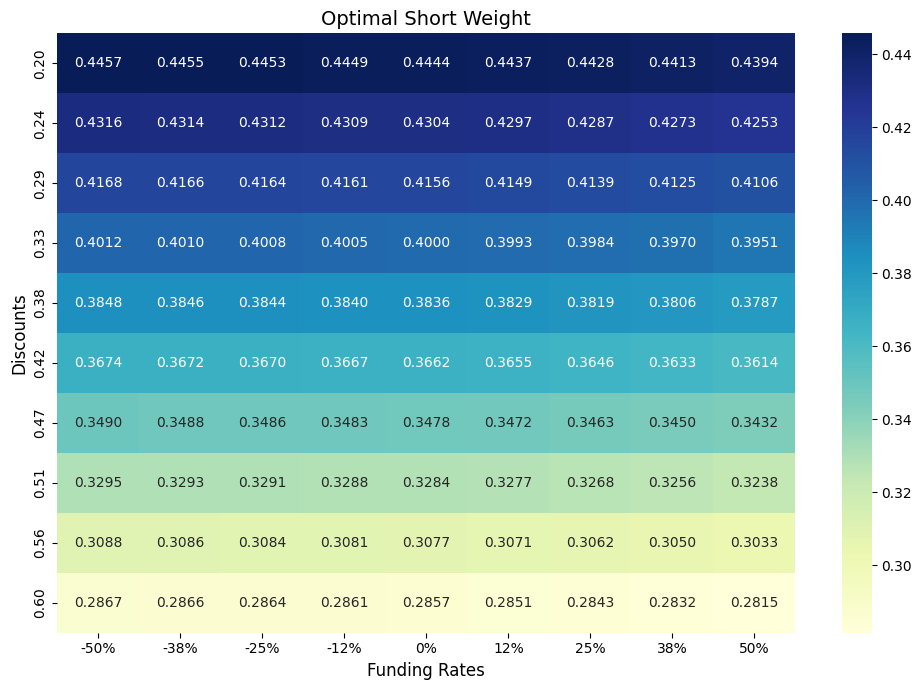

In [25]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

def compute_funding_factor(annual_rate_percent, period_fraction, compounding="8h", frequency_per_year=1095):
    r = annual_rate_percent / 100.0
    if compounding == "8h":
        return (1 + r / frequency_per_year) ** (frequency_per_year * period_fraction)
    else:
        return 1 + r * period_fraction

def compute_min_viable_loss(entry_short, discount, annual_rate, period_fraction, prices):
    entry_long = (1 - discount) * entry_short
    funding_factor = compute_funding_factor(annual_rate, period_fraction)

    def total_pnl_vector(w_short):
        w_long = 1 - w_short
        short_raw_pnl = np.maximum(entry_short - prices, 0) * w_short
        funding_cost = (funding_factor - 1) * w_short
        short_pnl = short_raw_pnl + funding_cost
        long_pnl = (prices - entry_long) * w_long
        return short_pnl + long_pnl

    def objective(w):
        return w[0]

    def find_min_loss(tol=1e-3, max_iter=40):
        low = 0.0
        high = 0.5
        optimal_weight = np.nan
        for _ in range(max_iter):
            mid = (low + high) / 2

            def constraint(w):
                return np.min(total_pnl_vector(w[0])) + mid

            result = minimize(
                objective,
                x0=[0.7],
                bounds=[(0, 1)],
                constraints={"type": "ineq", "fun": constraint},
                method='SLSQP',
                options={"maxiter": 300, "ftol": 1e-8, "disp": False}
            )

            if result.success:
                optimal_weight = result.x[0]
                high = mid
            else:
                low = mid

            if high - low < tol:
                break

        return high, optimal_weight

    return find_min_loss()

# Parameters
entry_short = 150
prices = np.linspace(0, 500, 500)
funding_rates = np.linspace(-50, 50, 9)
discounts = np.linspace(0.2, 0.6, 10)
periods = [34/12]  # 22 months

# Run simulation
results = {}
weights = {}

for period in periods:
    Z = np.zeros((len(discounts), len(funding_rates)))
    W = np.zeros_like(Z)
    for i in tqdm(range(len(discounts)), desc=f"Period: {period:.2f} yrs"):
        discount = discounts[i]
        for j, rate in enumerate(funding_rates):
            loss, weight = compute_min_viable_loss(entry_short, discount, rate, period, prices)
            Z[i, j] = loss
            W[i, j] = weight
    results[period] = Z
    weights[period] = W

# Display only the Optimal Short Weight table
weight_df = pd.DataFrame(weights[periods[0]], index=[f"{d:.2f}" for d in discounts], columns=[f"{r:.0f}%" for r in funding_rates])

plt.figure(figsize=(10, 7))
sns.heatmap(weight_df, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title("Optimal Short Weight", fontsize=14)
plt.xlabel("Funding Rates", fontsize=12)
plt.ylabel("Discounts", fontsize=12)

plt.tight_layout()
plt.show()
